In [ ]:
import itertools
import os
import statistics
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import PIL
import PIL.Image
from google.colab import drive
import pandas as pd
from keras_preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle 
import sklearn
import sklearn.model_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer
from keras import backend as K
from sklearn.utils import class_weight 
import pathlib
import itertools
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, auc,  roc_curve, balanced_accuracy_score, cohen_kappa_score
from scipy import interp
import time
import sys

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.8.0
Hub version: 0.12.0
GPU is NOT AVAILABLE


In [ ]:
model_name = "resnet_v2_50" # @param ['efficientnetv2-s', 'efficientnetv2-m', 'efficientnetv2-l', 'efficientnetv2-s-21k', 'efficientnetv2-m-21k', 'efficientnetv2-l-21k', 'efficientnetv2-xl-21k', 'efficientnetv2-b0-21k', 'efficientnetv2-b1-21k', 'efficientnetv2-b2-21k', 'efficientnetv2-b3-21k', 'efficientnetv2-s-21k-ft1k', 'efficientnetv2-m-21k-ft1k', 'efficientnetv2-l-21k-ft1k', 'efficientnetv2-xl-21k-ft1k', 'efficientnetv2-b0-21k-ft1k', 'efficientnetv2-b1-21k-ft1k', 'efficientnetv2-b2-21k-ft1k', 'efficientnetv2-b3-21k-ft1k', 'efficientnetv2-b0', 'efficientnetv2-b1', 'efficientnetv2-b2', 'efficientnetv2-b3', 'efficientnet_b0', 'efficientnet_b1', 'efficientnet_b2', 'efficientnet_b3', 'efficientnet_b4', 'efficientnet_b5', 'efficientnet_b6', 'efficientnet_b7', 'bit_s-r50x1', 'inception_v3', 'inception_resnet_v2', 'resnet_v1_50', 'resnet_v1_101', 'resnet_v1_152', 'resnet_v2_50', 'resnet_v2_101', 'resnet_v2_152', 'nasnet_large', 'nasnet_mobile', 'pnasnet_large', 'mobilenet_v1_100_224','mobilenet_v2_100_224', 'mobilenet_v2_130_224', 'mobilenet_v2_140_224', 'mobilenet_v3_small_100_224', 'mobilenet_v3_small_075_224', 'mobilenet_v3_large_100_224', 'mobilenet_v3_large_075_224']

model_handle_map = {
  "efficientnetv2-s": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_s/feature_vector/2",
  "efficientnetv2-m": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_m/feature_vector/2",
  "efficientnetv2-l": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_l/feature_vector/2",
  "efficientnetv2-s-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_s/feature_vector/2",
  "efficientnetv2-m-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_m/feature_vector/2",
  "efficientnetv2-l-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_l/feature_vector/2",
  "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
  "efficientnetv2-b0-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b0/feature_vector/2",
  "efficientnetv2-b1-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b1/feature_vector/2",
  "efficientnetv2-b2-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b2/feature_vector/2",
  "efficientnetv2-b3-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_b3/feature_vector/2",
  "efficientnetv2-s-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_s/feature_vector/2",
  "efficientnetv2-m-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_m/feature_vector/2",
  "efficientnetv2-l-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_l/feature_vector/2",
  "efficientnetv2-xl-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_xl/feature_vector/2",
  "efficientnetv2-b0-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2",
  "efficientnetv2-b1-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b1/feature_vector/2",
  "efficientnetv2-b2-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b2/feature_vector/2",
  "efficientnetv2-b3-21k-ft1k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b3/feature_vector/2",
  "efficientnetv2-b0": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2",
  "efficientnetv2-b1": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b1/feature_vector/2",
  "efficientnetv2-b2": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b2/feature_vector/2",
  "efficientnetv2-b3": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b3/feature_vector/2",
  "efficientnet_b0": "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1",
  "efficientnet_b1": "https://tfhub.dev/tensorflow/efficientnet/b1/feature-vector/1",
  "efficientnet_b2": "https://tfhub.dev/tensorflow/efficientnet/b2/feature-vector/1",
  "efficientnet_b3": "https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1",
  "efficientnet_b4": "https://tfhub.dev/tensorflow/efficientnet/b4/feature-vector/1",
  "efficientnet_b5": "https://tfhub.dev/tensorflow/efficientnet/b5/feature-vector/1",
  "efficientnet_b6": "https://tfhub.dev/tensorflow/efficientnet/b6/feature-vector/1",
  "efficientnet_b7": "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1",
  "bit_s-r50x1": "https://tfhub.dev/google/bit/s-r50x1/1",
  "inception_v3": "https://tfhub.dev/google/imagenet/inception_v3/feature-vector/4",
  "inception_resnet_v2": "https://tfhub.dev/google/imagenet/inception_resnet_v2/feature-vector/4",
  "resnet_v1_50": "https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5",
  "resnet_v1_101": "https://tfhub.dev/google/imagenet/resnet_v1_101/feature-vector/4",
  "resnet_v1_152": "https://tfhub.dev/google/imagenet/resnet_v1_152/feature-vector/4",
  "resnet_v2_50": "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5",
  "resnet_v2_101": "https://tfhub.dev/google/imagenet/resnet_v2_101/feature-vector/4",
  "resnet_v2_152": "https://tfhub.dev/google/imagenet/resnet_v2_152/feature-vector/4",
  "nasnet_large": "https://tfhub.dev/google/imagenet/nasnet_large/feature_vector/4",
  "nasnet_mobile": "https://tfhub.dev/google/imagenet/nasnet_mobile/feature_vector/4",
  "pnasnet_large": "https://tfhub.dev/google/imagenet/pnasnet_large/feature_vector/4",
  "mobilenet_v1_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v1_100_224/feature_vector/5",
  "mobilenet_v2_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/5",
  "mobilenet_v2_130_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/feature_vector/5",
  "mobilenet_v2_140_224": "https://tfhub.dev/google/imagenet/mobilenet_v2_140_224/feature_vector/5",
  "mobilenet_v3_small_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_100_224/feature_vector/5",
  "mobilenet_v3_small_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_small_075_224/feature_vector/5",
  "mobilenet_v3_large_100_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_100_224/feature_vector/5",
  "mobilenet_v3_large_075_224": "https://tfhub.dev/google/imagenet/mobilenet_v3_large_075_224/feature_vector/5",
}

model_image_size_map = {
  "efficientnetv2-s": 384,
  "efficientnetv2-m": 480,
  "efficientnetv2-l": 480,
  "efficientnetv2-b0": 224,
  "efficientnetv2-b1": 240,
  "efficientnetv2-b2": 260,
  "efficientnetv2-b3": 300,
  "efficientnetv2-s-21k": 384,
  "efficientnetv2-m-21k": 480,
  "efficientnetv2-l-21k": 480,
  "efficientnetv2-xl-21k": 512,
  "efficientnetv2-b0-21k": 224,
  "efficientnetv2-b1-21k": 240,
  "efficientnetv2-b2-21k": 260,
  "efficientnetv2-b3-21k": 300,
  "efficientnetv2-s-21k-ft1k": 384,
  "efficientnetv2-m-21k-ft1k": 480,
  "efficientnetv2-l-21k-ft1k": 480,
  "efficientnetv2-xl-21k-ft1k": 512,
  "efficientnetv2-b0-21k-ft1k": 224,
  "efficientnetv2-b1-21k-ft1k": 240,
  "efficientnetv2-b2-21k-ft1k": 260,
  "efficientnetv2-b3-21k-ft1k": 300, 
  "efficientnet_b0": 224,
  "efficientnet_b1": 240,
  "efficientnet_b2": 260,
  "efficientnet_b3": 300,
  "efficientnet_b4": 380,
  "efficientnet_b5": 456,
  "efficientnet_b6": 528,
  "efficientnet_b7": 600,
  "inception_v3": 299,
  "inception_resnet_v2": 299,
  "nasnet_large": 331,
  "pnasnet_large": 331,
}

model_handle = model_handle_map.get(model_name)
pixels = model_image_size_map.get(model_name, 224)

print(f"Selected model: {model_name} : {model_handle}")

IMAGE_SIZE = (pixels, pixels)
print(f"Input size {IMAGE_SIZE}")

BATCH_SIZE = 16
EPOCHS = 100
print('Batch size: ', BATCH_SIZE, 'Epoch: ', EPOCHS)

Selected model: resnet_v2_50 : https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
Input size (224, 224)
Batch size:  16 Epoch:  100


In [ ]:
drive.mount('/content/drive')

sn_name = 'Macenko'
sn_label = 'M'
version = 'V3'

save_dir = '/content/drive/MyDrive/Wingates FYP/Codes Files/Own Codes/'
#for cv
save_model = f"/content/drive/MyDrive/Wingates FYP/Codes Files/Own Codes/{version}_SN_{sn_label}_{model_name}_CrossValidation400x_"
print(save_model)
#for test set
checkpoint_path = f'/content/drive/MyDrive/Wingates FYP/Codes Files/Own Codes/{version}_SN_{sn_label}_cp_{model_name}_400x_CV.h5'
print(checkpoint_path)

Mounted at /content/drive
/content/drive/MyDrive/Wingates FYP/Codes Files/Own Codes/V3_SN_M_resnet_v2_50_CrossValidation400x_
/content/drive/MyDrive/Wingates FYP/Codes Files/Own Codes/V3_SN_M_cp_resnet_v2_50_400x_CV.h5


In [ ]:
#Create one time only
metrics = {'Balanced Accuracy': [], 'Macro Precision': [], 'Macro Recall': [], 'Macro F1score': [], 'Kappa Score': [], 'Inference Time': [], 'Training Time': []}
df = pd.DataFrame(metrics) 
df.to_csv(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/Result/{version}_SN_{sn_label}_{model_name}_result.csv', index=False) 


In [ ]:
metrics = {'Model Name': [], 'Balanced Accuracy': [], 'Macro Precision': [], 'Macro Recall': [], 'Macro F1score': [], 'Kappa Score': []}
df = pd.DataFrame(metrics) 
df.to_csv(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/Result/{version}_SN_{sn_label}_test_result2.csv', index=False) 

In [ ]:
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = K.variable(weights)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * K.log(y_pred) * weights
        loss = -K.sum(loss, -1)
        return loss
    
    return loss

def get_model_name(k):
    return version+'_SN_'+sn_label+'_'+model_name+'_CrossValidation400x_'+str(k)+'.h5'

def plot_confusion_matrix(cm, classes, dir,
                          normalize=False,
                          title='Confusion matrix',
                          
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig(dir)
    plt.close()


class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

def create_model(class_weights):
  print("Building model with", model_handle)
  do_fine_tuning = False

  data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),                                       
  ])


  base_model = hub.KerasLayer(model_handle, trainable=do_fine_tuning)
  dense_layer = tf.keras.layers.Dense(256, activation='relu')
  prediction_layer = tf.keras.layers.Dense(4, activation='softmax')

  inputs = tf.keras.Input(shape=IMAGE_SIZE+(3,))
  x = data_augmentation(inputs)
  x = base_model(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = dense_layer(x)
  x = tf.keras.layers.Dropout(0.4)(x) 
  outputs = prediction_layer(x)
  model = tf.keras.Model(inputs, outputs, name = model_name)

  weights = np.fromiter(class_weights.values(), dtype=float)
  print(weights)
  loss = weighted_categorical_crossentropy(weights)

  model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
  loss=loss,
  metrics=['accuracy'])

  model.summary()
  
  return model

def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))



Cross validation: 1
Found 568 validated image filenames belonging to 4 classes.
Found 143 validated image filenames belonging to 4 classes.
{0: 0.3776595744680851, 1: 2.0579710144927534, 2: 2.1846153846153844, 3: 2.4482758620689653}
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
[0.37765957 2.05797101 2.18461538 2.44827586]
Model: "resnet_v2_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                     

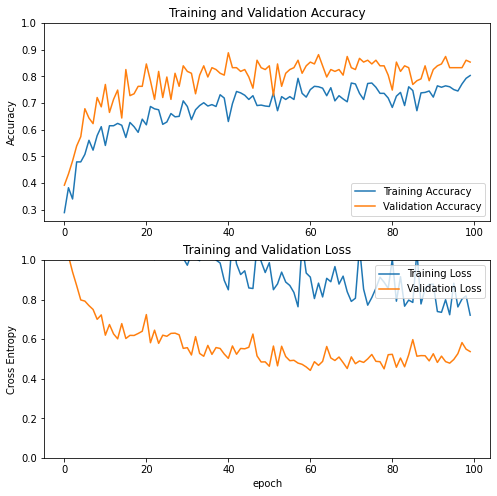

Total training time:  0.34791715933216943 hour
resnet_v2_50  loaded
9/9 [==============================] - 2s 239ms/step - loss: 0.5030 - accuracy: 0.8881
Confusion matrix, without normalization
[[85  2  7  0]
 [ 1 15  0  1]
 [ 0  2 15  0]
 [ 0  1  2 12]]
Normalized confusion matrix
[[0.90425532 0.0212766  0.07446809 0.        ]
 [0.05882353 0.88235294 0.         0.05882353]
 [0.         0.11764706 0.88235294 0.        ]
 [0.         0.06666667 0.13333333 0.8       ]]
[[85  2  7  0]
 [ 1 15  0  1]
 [ 0  2 15  0]
 [ 0  1  2 12]]

Accuracy: 0.8881


Balanced Accuracy: 0.8672

Micro Precision: 0.8881
Micro Recall: 0.8881
Micro F1-score: 0.8881

Macro Precision: 0.8216
Macro Recall: 0.8672
Macro F1-score: 0.8360

Kappa score: 0.7997
Weighted Precision: 0.9100
Weighted Recall: 0.8881
Weighted F1-score: 0.8941

Classification Report

              precision    recall  f1-score   support

     Grade 0       0.99      0.90      0.94        94
     Grade 1       0.75      0.88      0.81        

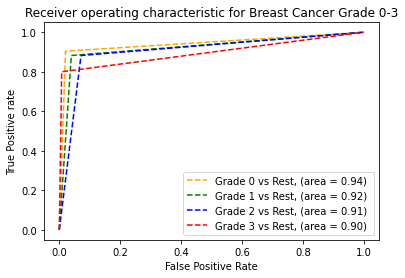

In [ ]:
fold_var = 1
print(f'Cross validation: {fold_var}')

training_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_training_data_400x{fold_var}.csv')
validation_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_validation_data_400x{fold_var}.csv')



train_data_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(training_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)
valid_data_generator  = ImageDataGenerator(rescale=1./255).flow_from_dataframe(validation_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)



class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(training_data['grade']),y = training_data['grade'])
class_weights = dict(enumerate(class_weights))
print(class_weights)


model = create_model(class_weights)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')


time_callback = TimeHistory()

callbacks_list = [checkpoint, time_callback]

history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
					class_weight = class_weights,
			    validation_data=valid_data_generator)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_TVC.png')
plt.show()

total_training_times = time_callback.times
summ = np.sum(total_training_times)
training_time = summ/3600
print('Total training time: ', training_time, 'hour')

model.load_weights(save_model+str(fold_var)+".h5")
print(model_name, " loaded")

model.evaluate(valid_data_generator)
nb_samples = valid_data_generator.n

steps = int(np.ceil(nb_samples/BATCH_SIZE))
x, y = [], []
for i in range(steps):
    a , b = valid_data_generator.next()
    y.extend(b)
    x.extend(a)

x = np.array(x)
y = np.array(y)
predict = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))

y_pred = np.argmax(predict, axis=1)
y_label = np.argmax(y, axis=1)

cm = confusion_matrix(y_label, y_pred)
plot_confusion_matrix(cm, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_CV{fold_var}.png' )
plot_confusion_matrix(cm, normalize = True, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_normalise_CV{fold_var}.png' )
print(cm)
 
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

print('Micro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

print('Weighted Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_label, y_pred, average='weighted')))



print('\nClassification Report\n')
print(classification_report(y_label, y_pred, target_names=['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3']))

baccuracy = balanced_accuracy_score(y_label, y_pred)
macro_precision = precision_score(y_label, y_pred, average='macro')
macro_recall = recall_score(y_label, y_pred, average='macro')
macro_f1score = f1_score(y_label, y_pred, average='macro')
kappa_score = cohen_kappa_score(y_label, y_pred)


y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
plt.title('Receiver operating characteristic for Breast Cancer Grade 0-3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_ROC.png')

pred_time_list=[]
for i in range(10):
    start = time.process_time() 
    result = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))
    end = time.process_time()
    pred_time_list.append((end-start)/nb_samples)
inference_time = sum(pred_time_list)/10
print('Inference time: ',inference_time, 'second') 

df = pd.DataFrame({'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score, 'Inference Time': inference_time, 'Training Time': training_time}, index=[0])  
df.to_csv(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/Result/{version}_SN_{sn_label}_{model_name}_result.csv',  mode='a', index=False, header=False) 


Cross validation: 2
Found 569 validated image filenames belonging to 4 classes.
Found 142 validated image filenames belonging to 4 classes.
{0: 0.3783244680851064, 1: 2.0615942028985508, 2: 2.1884615384615387, 3: 2.4110169491525424}
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
[0.37832447 2.0615942  2.18846154 2.41101695]
Model: "resnet_v2_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_1 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dropout_2 (Dropout)         (None, 2048)              0         
                     

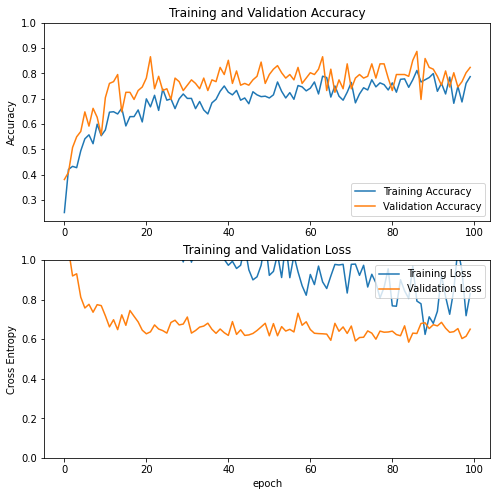

Total training time:  0.30165619247489506 hour
resnet_v2_50  loaded
9/9 [==============================] - 2s 236ms/step - loss: 0.6289 - accuracy: 0.8873
Confusion matrix, without normalization
[[88  3  3  0]
 [ 1 14  2  0]
 [ 1  1 14  1]
 [ 0  2  2 10]]
Normalized confusion matrix
[[0.93617021 0.03191489 0.03191489 0.        ]
 [0.05882353 0.82352941 0.11764706 0.        ]
 [0.05882353 0.05882353 0.82352941 0.05882353]
 [0.         0.14285714 0.14285714 0.71428571]]
[[88  3  3  0]
 [ 1 14  2  0]
 [ 1  1 14  1]
 [ 0  2  2 10]]

Accuracy: 0.8873


Balanced Accuracy: 0.8244

Micro Precision: 0.8873
Micro Recall: 0.8873
Micro F1-score: 0.8873

Macro Precision: 0.8134
Macro Recall: 0.8244
Macro F1-score: 0.8125

Kappa score: 0.7907
Weighted Precision: 0.9005
Weighted Recall: 0.8873
Weighted F1-score: 0.8909

Classification Report

              precision    recall  f1-score   support

     Grade 0       0.98      0.94      0.96        94
     Grade 1       0.70      0.82      0.76        

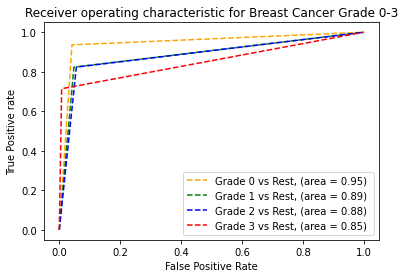

In [ ]:
fold_var = 2
print(f'Cross validation: {fold_var}')

training_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_training_data_400x{fold_var}.csv')
validation_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_validation_data_400x{fold_var}.csv')



train_data_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(training_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)
valid_data_generator  = ImageDataGenerator(rescale=1./255).flow_from_dataframe(validation_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)



class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(training_data['grade']),y = training_data['grade'])
class_weights = dict(enumerate(class_weights))
print(class_weights)


model = create_model(class_weights)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')


time_callback = TimeHistory()

callbacks_list = [checkpoint, time_callback]

history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
					class_weight = class_weights,
			    validation_data=valid_data_generator)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_TVC.png')
plt.show()

total_training_times = time_callback.times
summ = np.sum(total_training_times)
training_time = summ/3600
print('Total training time: ', training_time, 'hour')

model.load_weights(save_model+str(fold_var)+".h5")
print(model_name, " loaded")

model.evaluate(valid_data_generator)
nb_samples = valid_data_generator.n

steps = int(np.ceil(nb_samples/BATCH_SIZE))
x, y = [], []
for i in range(steps):
    a , b = valid_data_generator.next()
    y.extend(b)
    x.extend(a)

x = np.array(x)
y = np.array(y)
predict = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))

y_pred = np.argmax(predict, axis=1)
y_label = np.argmax(y, axis=1)

cm = confusion_matrix(y_label, y_pred)
plot_confusion_matrix(cm, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_CV{fold_var}.png' )
plot_confusion_matrix(cm, normalize = True, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_normalise_CV{fold_var}.png' )
print(cm)
 
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

print('Micro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

print('Weighted Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_label, y_pred, average='weighted')))



print('\nClassification Report\n')
print(classification_report(y_label, y_pred, target_names=['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3']))

baccuracy = balanced_accuracy_score(y_label, y_pred)
macro_precision = precision_score(y_label, y_pred, average='macro')
macro_recall = recall_score(y_label, y_pred, average='macro')
macro_f1score = f1_score(y_label, y_pred, average='macro')
kappa_score = cohen_kappa_score(y_label, y_pred)


y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
plt.title('Receiver operating characteristic for Breast Cancer Grade 0-3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_ROC.png')

pred_time_list=[]
for i in range(10):
    start = time.process_time() 
    result = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))
    end = time.process_time()
    pred_time_list.append((end-start)/nb_samples)
inference_time = sum(pred_time_list)/10
print('Inference time: ',inference_time, 'second') 

df = pd.DataFrame({'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score, 'Inference Time': inference_time, 'Training Time': training_time}, index=[0])  
df.to_csv(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/Result/{version}_SN_{sn_label}_{model_name}_result.csv',  mode='a', index=False, header=False) 


Cross validation: 3
Found 569 validated image filenames belonging to 4 classes.
Found 142 validated image filenames belonging to 4 classes.
{0: 0.3783244680851064, 1: 2.0919117647058822, 2: 2.1553030303030303, 3: 2.4110169491525424}
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
[0.37832447 2.09191176 2.15530303 2.41101695]
Model: "resnet_v2_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_2 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dropout_4 (Dropout)         (None, 2048)              0         
                     

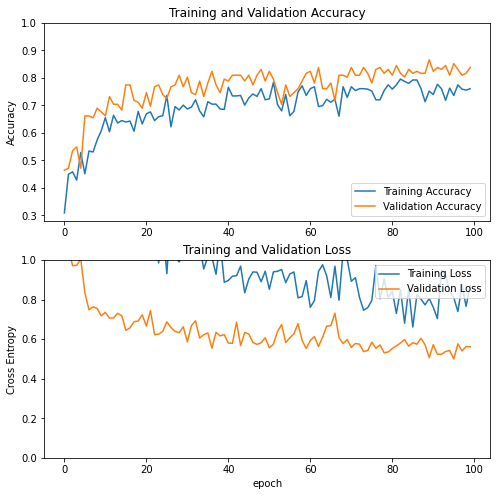

Total training time:  0.3077144379085965 hour
resnet_v2_50  loaded
9/9 [==============================] - 2s 238ms/step - loss: 0.5066 - accuracy: 0.8662
Confusion matrix, without normalization
[[83  4  7  0]
 [ 0 15  3  0]
 [ 0  3 13  0]
 [ 0  1  1 12]]
Normalized confusion matrix
[[0.88297872 0.04255319 0.07446809 0.        ]
 [0.         0.83333333 0.16666667 0.        ]
 [0.         0.1875     0.8125     0.        ]
 [0.         0.07142857 0.07142857 0.85714286]]
[[83  4  7  0]
 [ 0 15  3  0]
 [ 0  3 13  0]
 [ 0  1  1 12]]

Accuracy: 0.8662


Balanced Accuracy: 0.8465

Micro Precision: 0.8662
Micro Recall: 0.8662
Micro F1-score: 0.8662

Macro Precision: 0.7985
Macro Recall: 0.8465
Macro F1-score: 0.8107

Kappa score: 0.7633
Weighted Precision: 0.9043
Weighted Recall: 0.8662
Weighted F1-score: 0.8778

Classification Report

              precision    recall  f1-score   support

     Grade 0       1.00      0.88      0.94        94
     Grade 1       0.65      0.83      0.73        1

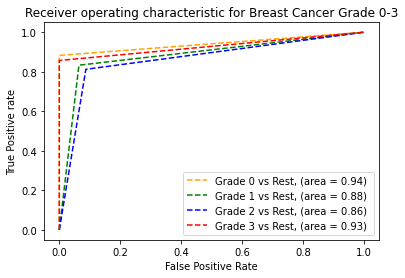

In [ ]:
fold_var = 3
print(f'Cross validation: {fold_var}')

training_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_training_data_400x{fold_var}.csv')
validation_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_validation_data_400x{fold_var}.csv')



train_data_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(training_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)
valid_data_generator  = ImageDataGenerator(rescale=1./255).flow_from_dataframe(validation_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)



class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(training_data['grade']),y = training_data['grade'])
class_weights = dict(enumerate(class_weights))
print(class_weights)


model = create_model(class_weights)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')


time_callback = TimeHistory()

callbacks_list = [checkpoint, time_callback]

history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
					class_weight = class_weights,
			    validation_data=valid_data_generator)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_TVC.png')
plt.show()

total_training_times = time_callback.times
summ = np.sum(total_training_times)
training_time = summ/3600
print('Total training time: ', training_time, 'hour')

model.load_weights(save_model+str(fold_var)+".h5")
print(model_name, " loaded")

model.evaluate(valid_data_generator)
nb_samples = valid_data_generator.n

steps = int(np.ceil(nb_samples/BATCH_SIZE))
x, y = [], []
for i in range(steps):
    a , b = valid_data_generator.next()
    y.extend(b)
    x.extend(a)

x = np.array(x)
y = np.array(y)
predict = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))

y_pred = np.argmax(predict, axis=1)
y_label = np.argmax(y, axis=1)

cm = confusion_matrix(y_label, y_pred)
plot_confusion_matrix(cm, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_CV{fold_var}.png' )
plot_confusion_matrix(cm, normalize = True, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_normalise_CV{fold_var}.png' )
print(cm)
 
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

print('Micro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

print('Weighted Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_label, y_pred, average='weighted')))



print('\nClassification Report\n')
print(classification_report(y_label, y_pred, target_names=['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3']))

baccuracy = balanced_accuracy_score(y_label, y_pred)
macro_precision = precision_score(y_label, y_pred, average='macro')
macro_recall = recall_score(y_label, y_pred, average='macro')
macro_f1score = f1_score(y_label, y_pred, average='macro')
kappa_score = cohen_kappa_score(y_label, y_pred)


y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
plt.title('Receiver operating characteristic for Breast Cancer Grade 0-3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_ROC.png')

pred_time_list=[]
for i in range(10):
    start = time.process_time() 
    result = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))
    end = time.process_time()
    pred_time_list.append((end-start)/nb_samples)
inference_time = sum(pred_time_list)/10
print('Inference time: ',inference_time, 'second') 

df = pd.DataFrame({'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score, 'Inference Time': inference_time, 'Training Time': training_time}, index=[0])  
df.to_csv(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/Result/{version}_SN_{sn_label}_{model_name}_result.csv',  mode='a', index=False, header=False) 


Cross validation: 4
Found 569 validated image filenames belonging to 4 classes.
Found 142 validated image filenames belonging to 4 classes.
{0: 0.3783244680851064, 1: 2.0615942028985508, 2: 2.1553030303030303, 3: 2.4525862068965516}
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
[0.37832447 2.0615942  2.15530303 2.45258621]
Model: "resnet_v2_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_3 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_3 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dropout_6 (Dropout)         (None, 2048)              0         
                     

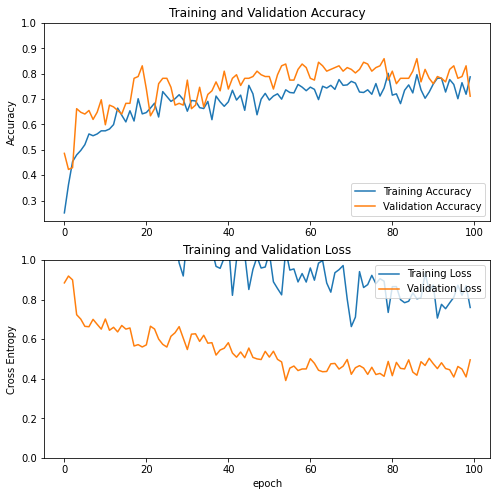

Total training time:  0.2990419271919462 hour
resnet_v2_50  loaded
9/9 [==============================] - 2s 230ms/step - loss: 0.4123 - accuracy: 0.8592
Confusion matrix, without normalization
[[83  3  8  0]
 [ 1 10  5  1]
 [ 0  0 15  1]
 [ 0  0  1 14]]
Normalized confusion matrix
[[0.88297872 0.03191489 0.08510638 0.        ]
 [0.05882353 0.58823529 0.29411765 0.05882353]
 [0.         0.         0.9375     0.0625    ]
 [0.         0.         0.06666667 0.93333333]]
[[83  3  8  0]
 [ 1 10  5  1]
 [ 0  0 15  1]
 [ 0  0  1 14]]

Accuracy: 0.8592


Balanced Accuracy: 0.8355

Micro Precision: 0.8592
Micro Recall: 0.8592
Micro F1-score: 0.8592

Macro Precision: 0.7874
Macro Recall: 0.8355
Macro F1-score: 0.7923

Kappa score: 0.7496
Weighted Precision: 0.8969
Weighted Recall: 0.8592
Weighted F1-score: 0.8677

Classification Report

              precision    recall  f1-score   support

     Grade 0       0.99      0.88      0.93        94
     Grade 1       0.77      0.59      0.67        1

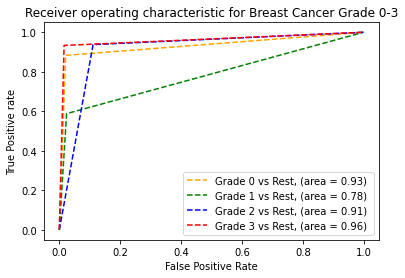

In [ ]:
fold_var = 4
print(f'Cross validation: {fold_var}')

training_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_training_data_400x{fold_var}.csv')
validation_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_validation_data_400x{fold_var}.csv')



train_data_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(training_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)
valid_data_generator  = ImageDataGenerator(rescale=1./255).flow_from_dataframe(validation_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)



class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(training_data['grade']),y = training_data['grade'])
class_weights = dict(enumerate(class_weights))
print(class_weights)


model = create_model(class_weights)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')


time_callback = TimeHistory()

callbacks_list = [checkpoint, time_callback]

history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
					class_weight = class_weights,
			    validation_data=valid_data_generator)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_TVC.png')
plt.show()

total_training_times = time_callback.times
summ = np.sum(total_training_times)
training_time = summ/3600
print('Total training time: ', training_time, 'hour')

model.load_weights(save_model+str(fold_var)+".h5")
print(model_name, " loaded")

model.evaluate(valid_data_generator)
nb_samples = valid_data_generator.n

steps = int(np.ceil(nb_samples/BATCH_SIZE))
x, y = [], []
for i in range(steps):
    a , b = valid_data_generator.next()
    y.extend(b)
    x.extend(a)

x = np.array(x)
y = np.array(y)
predict = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))

y_pred = np.argmax(predict, axis=1)
y_label = np.argmax(y, axis=1)

cm = confusion_matrix(y_label, y_pred)
plot_confusion_matrix(cm, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_CV{fold_var}.png' )
plot_confusion_matrix(cm, normalize = True, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_normalise_CV{fold_var}.png' )
print(cm)
 
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

print('Micro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

print('Weighted Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_label, y_pred, average='weighted')))



print('\nClassification Report\n')
print(classification_report(y_label, y_pred, target_names=['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3']))

baccuracy = balanced_accuracy_score(y_label, y_pred)
macro_precision = precision_score(y_label, y_pred, average='macro')
macro_recall = recall_score(y_label, y_pred, average='macro')
macro_f1score = f1_score(y_label, y_pred, average='macro')
kappa_score = cohen_kappa_score(y_label, y_pred)


y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
plt.title('Receiver operating characteristic for Breast Cancer Grade 0-3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_ROC.png')

pred_time_list=[]
for i in range(10):
    start = time.process_time() 
    result = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))
    end = time.process_time()
    pred_time_list.append((end-start)/nb_samples)
inference_time = sum(pred_time_list)/10
print('Inference time: ',inference_time, 'second') 

df = pd.DataFrame({'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score, 'Inference Time': inference_time, 'Training Time': training_time}, index=[0])  
df.to_csv(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/Result/{version}_SN_{sn_label}_{model_name}_result.csv',  mode='a', index=False, header=False) 


Cross validation: 5
Found 569 validated image filenames belonging to 4 classes.
Found 142 validated image filenames belonging to 4 classes.
{0: 0.3783244680851064, 1: 2.0615942028985508, 2: 2.1553030303030303, 3: 2.4525862068965516}
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
[0.37832447 2.0615942  2.15530303 2.45258621]
Model: "resnet_v2_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_4 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 keras_layer_4 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                     

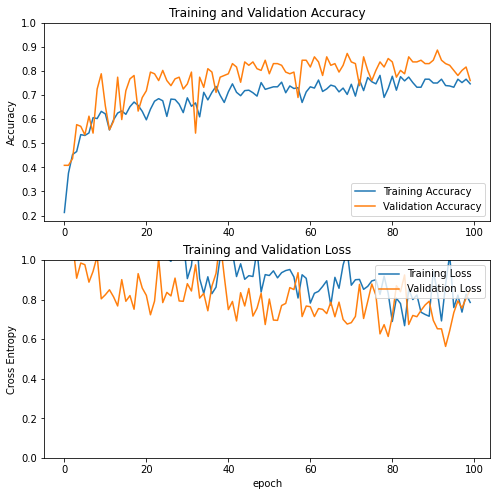

Total training time:  0.3103476366069582 hour
resnet_v2_50  loaded
9/9 [==============================] - 2s 241ms/step - loss: 0.6527 - accuracy: 0.8873
Confusion matrix, without normalization
[[90  1  3  0]
 [ 0 11  5  1]
 [ 0  2 14  0]
 [ 0  1  3 11]]
Normalized confusion matrix
[[0.95744681 0.0106383  0.03191489 0.        ]
 [0.         0.64705882 0.29411765 0.05882353]
 [0.         0.125      0.875      0.        ]
 [0.         0.06666667 0.2        0.73333333]]
[[90  1  3  0]
 [ 0 11  5  1]
 [ 0  2 14  0]
 [ 0  1  3 11]]

Accuracy: 0.8873


Balanced Accuracy: 0.8032

Micro Precision: 0.8873
Micro Recall: 0.8873
Micro F1-score: 0.8873

Macro Precision: 0.8025
Macro Recall: 0.8032
Macro F1-score: 0.7909

Kappa score: 0.7910
Weighted Precision: 0.9097
Weighted Recall: 0.8873
Weighted F1-score: 0.8929

Classification Report

              precision    recall  f1-score   support

     Grade 0       1.00      0.96      0.98        94
     Grade 1       0.73      0.65      0.69        1

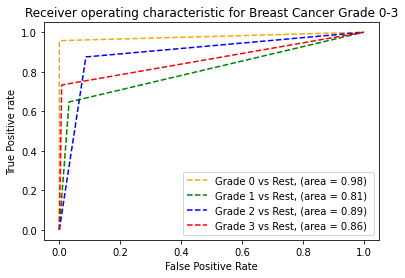

In [ ]:
fold_var = 5
print(f'Cross validation: {fold_var}')

training_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_training_data_400x{fold_var}.csv')
validation_data = pd.read_csv(f'/content/drive/MyDrive/Wingates FYP/CSV2/{version}_SN_{sn_label}_validation_data_400x{fold_var}.csv')



train_data_generator = ImageDataGenerator(rescale=1./255).flow_from_dataframe(training_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)
valid_data_generator  = ImageDataGenerator(rescale=1./255).flow_from_dataframe(validation_data, x_col = "path", y_col = "grade", class_mode = "categorical", shuffle = True, seed = 123, batch_size = BATCH_SIZE, target_size= IMAGE_SIZE)



class_weights = class_weight.compute_class_weight(class_weight='balanced',classes = np.unique(training_data['grade']),y = training_data['grade'])
class_weights = dict(enumerate(class_weights))
print(class_weights)


model = create_model(class_weights)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+get_model_name(fold_var), 
							monitor='val_accuracy', verbose=1, 
							save_best_only=True, mode='max')


time_callback = TimeHistory()

callbacks_list = [checkpoint, time_callback]

history = model.fit(train_data_generator,
			    epochs=EPOCHS,
			    callbacks=callbacks_list,
					class_weight = class_weights,
			    validation_data=valid_data_generator)


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_TVC.png')
plt.show()

total_training_times = time_callback.times
summ = np.sum(total_training_times)
training_time = summ/3600
print('Total training time: ', training_time, 'hour')

model.load_weights(save_model+str(fold_var)+".h5")
print(model_name, " loaded")

model.evaluate(valid_data_generator)
nb_samples = valid_data_generator.n

steps = int(np.ceil(nb_samples/BATCH_SIZE))
x, y = [], []
for i in range(steps):
    a , b = valid_data_generator.next()
    y.extend(b)
    x.extend(a)

x = np.array(x)
y = np.array(y)
predict = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))

y_pred = np.argmax(predict, axis=1)
y_label = np.argmax(y, axis=1)

cm = confusion_matrix(y_label, y_pred)
plot_confusion_matrix(cm, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_CV{fold_var}.png' )
plot_confusion_matrix(cm, normalize = True, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_normalise_CV{fold_var}.png' )
print(cm)
 
print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

print('Micro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

print('Weighted Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_label, y_pred, average='weighted')))



print('\nClassification Report\n')
print(classification_report(y_label, y_pred, target_names=['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3']))

baccuracy = balanced_accuracy_score(y_label, y_pred)
macro_precision = precision_score(y_label, y_pred, average='macro')
macro_recall = recall_score(y_label, y_pred, average='macro')
macro_f1score = f1_score(y_label, y_pred, average='macro')
kappa_score = cohen_kappa_score(y_label, y_pred)


y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
plt.title('Receiver operating characteristic for Breast Cancer Grade 0-3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_CV{fold_var}_ROC.png')

pred_time_list=[]
for i in range(10):
    start = time.process_time() 
    result = model.predict(x, steps = np.ceil(nb_samples/BATCH_SIZE))
    end = time.process_time()
    pred_time_list.append((end-start)/nb_samples)
inference_time = sum(pred_time_list)/10
print('Inference time: ',inference_time, 'second') 

df = pd.DataFrame({'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score, 'Inference Time': inference_time, 'Training Time': training_time}, index=[0])  
df.to_csv(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/Result/{version}_SN_{sn_label}_{model_name}_result.csv',  mode='a', index=False, header=False) 


Found 711 files belonging to 4 classes.
Found 177 files belonging to 4 classes.
['Grade_0 ', 'Grade_1', 'Grade_2', 'Grade_3']
Building model with https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5
[0.37819149 2.06686047 2.16768293 2.43493151]
Model: "resnet_v2_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 keras_layer (KerasLayer)    (None, 2048)              23564800  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544 

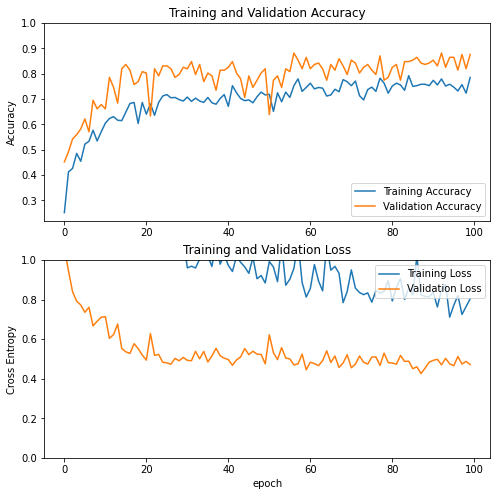

Total training time:  3.4564718135197956 hour
resnet_v2_50  loaded
12/12 [==============================] - 24s 2s/step - loss: 0.4700 - accuracy: 0.8814
Test accuracy : 0.8813559412956238
Confusion matrix, without normalization
[[111   4   1   2]
 [  0  16   3   2]
 [  0   2  15   3]
 [  0   2   2  14]]
Normalized confusion matrix
[[0.94067797 0.03389831 0.00847458 0.01694915]
 [0.         0.76190476 0.14285714 0.0952381 ]
 [0.         0.1        0.75       0.15      ]
 [0.         0.11111111 0.11111111 0.77777778]]
[[111   4   1   2]
 [  0  16   3   2]
 [  0   2  15   3]
 [  0   2   2  14]]

Accuracy: 0.8814


Balanced Accuracy: 0.8076

Micro Precision: 0.8814
Micro Recall: 0.8814
Micro F1-score: 0.8814

Macro Precision: 0.7619
Macro Recall: 0.8076
Macro F1-score: 0.7825

Kappa score: 0.7804
Weighted Precision: 0.8943
Weighted Recall: 0.8814
Weighted F1-score: 0.8863

Classification Report

              precision    recall  f1-score   support

     Grade 0       1.00      0.94      

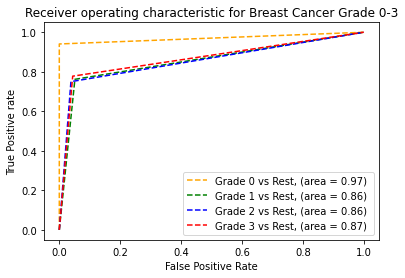

In [ ]:

train_dir =f'/content/drive/MyDrive/Wingates FYP/Dataset/{version} {sn_name} Normalised IDC Grading Dataset/Training Set'
test_dir =f'/content/drive/MyDrive/Wingates FYP/Dataset/{version} {sn_name} Normalised IDC Grading Dataset/Test Set'



train_dir = pathlib.Path(train_dir)
test_dir = pathlib.Path(test_dir)


train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  seed=123,
  image_size= IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_ds = tf.keras.utils.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=IMAGE_SIZE,
  batch_size=BATCH_SIZE,
  label_mode = 'categorical')

class_names = train_ds.class_names
print(class_names)

normalization_layer = tf.keras.layers.Rescaling(1. / 255)

train_ds = train_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))
test_ds = test_ds.map(lambda images, labels:
                    (normalization_layer(images), labels))

y = np.concatenate([y for x, y in train_ds], axis=0)
class_weights = generate_class_weights(y, multi_class=True, one_hot_encoded=True)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = create_model(class_weights)

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 

time_callback = TimeHistory()


history=model.fit(
  train_ds,
  validation_data=test_ds,
  epochs=EPOCHS,
  callbacks = [cp_callback, time_callback], 
 class_weight = class_weights
)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_T_TVC.png')
plt.show()


total_training_times = time_callback.times
summ = np.sum(total_training_times)
print('Total training time: ', summ/3600, 'hour')

model.load_weights(checkpoint_path)
print(model_name, " loaded")
loss, accuracy = model.evaluate(test_ds)
print('Test accuracy :', accuracy)

test_labels = np.concatenate([y for x, y in test_ds], axis=0)
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)
y_label = np.argmax(test_labels, axis=1)

cm = confusion_matrix(y_label, y_pred)
plot_confusion_matrix(cm, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_T.png' )
plot_confusion_matrix(cm, normalize = True, classes= ['Grade 0' , 'Grade 1', 'Grade 2','Grade 3'], dir = f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/Confusion Matrix/{model_name}_normalise_T.png' )
print(cm)

print('\nAccuracy: {:.4f}\n'.format(accuracy_score(y_label, y_pred)))
print('\nBalanced Accuracy: {:.4f}\n'.format(balanced_accuracy_score(y_label, y_pred)))

print('Micro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='micro')))
print('Micro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='micro')))
print('Micro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='micro')))

print('Macro Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='macro')))
print('Macro Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='macro')))
print('Macro F1-score: {:.4f}\n'.format(f1_score(y_label, y_pred, average='macro')))
print('Kappa score: {:.4f}'.format(cohen_kappa_score(y_label, y_pred)))

print('Weighted Precision: {:.4f}'.format(precision_score(y_label, y_pred, average='weighted')))
print('Weighted Recall: {:.4f}'.format(recall_score(y_label, y_pred, average='weighted')))
print('Weighted F1-score: {:.4f}'.format(f1_score(y_label, y_pred, average='weighted')))


print('\nClassification Report\n')
print(classification_report(y_label, y_pred, target_names=['Grade 0', 'Grade 1', 'Grade 2', 'Grade 3']))

baccuracy = balanced_accuracy_score(y_label, y_pred)
macro_precision = precision_score(y_label, y_pred, average='macro')
macro_recall = recall_score(y_label, y_pred, average='macro')
macro_f1score = f1_score(y_label, y_pred, average='macro')
kappa_score = cohen_kappa_score(y_label, y_pred)

y_pred = tf.keras.utils.to_categorical(y_pred, num_classes=4)
y_label = tf.keras.utils.to_categorical(y_label, num_classes=4)

# Plot ROC Curve
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 4
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_label[:,i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Grade 0 vs Rest, (area = %0.2f) ' % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Grade 1 vs Rest, (area = %0.2f) ' % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label='Grade 2 vs Rest, (area = %0.2f) ' % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='red', label='Grade 3 vs Rest, (area = %0.2f) ' % roc_auc[3])
plt.title('Receiver operating characteristic for Breast Cancer Grade 0-3')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/{sn_name} Figure/{model_name}_T_ROC.png')

pred_time_list=[]
for i in range(10):
    start = time.process_time() 
    result = model.predict(test_ds)
    end = time.process_time()
    pred_time_list.append((end-start)/177)
print('Inference time: ',sum(pred_time_list)/10, 'second') 




df = pd.DataFrame({'Model Name': model_name, 'Balanced Accuracy': baccuracy, 'Macro Precision': macro_precision, 'Macro Recall': macro_recall, 'Macro F1score': macro_f1score, 'Kappa Score': kappa_score}, index=[0])  
df.to_csv(f'/content/drive/MyDrive/Wingates FYP/Paper 2/{version}/Result/{version}_SN_{sn_label}_test_result2.csv',  mode='a', index=False, header=False) 

  